<a href="https://colab.research.google.com/github/ScarrryMary/Project_group24-25/blob/main/Seminar2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

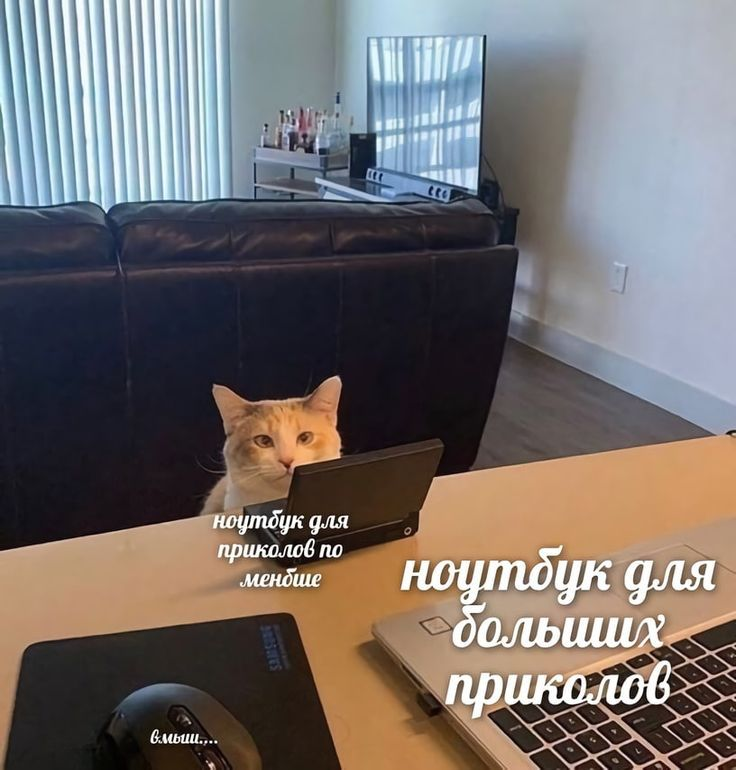

## Введение в атомистическое моделирование
Что такое «атомистическое моделирование», и что с его помощью можно сделать? В этом разделе представлен обзор.

Различные свойства материалов могут быть объяснены на атомном уровне. Например, механические свойства (упругие константы, модуль Юнга и т.д.), теплофизические свойства (удельная теплоемкость и т.д.), вязкость, химические реакции и т.д. Атомистическое моделирование может быть использовано для воспроизведения движения атомов или для анализа того, как атомы расположены в природе.

In [ ]:
!pip install ase==3.23.0 asap3

In [ ]:
import os

from IPython.display import HTML, Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation

from ase import Atoms
from ase.build import make_supercell
from ase.io import write
from ase.visualize import view

os.makedirs("output", exist_ok=True)

def view_x3d(atoms, idx=0):
    if isinstance(atoms[0], Atoms):
        # Assume this is a trajectory or struct list
        if (len(atoms) <= idx):
                print(f"The specified index exceeds the length of the trajectory. The length of the trajectory is {len(atoms)}.")
        return view(atoms[idx], viewer="x3d")
    else:
        return view(atoms, viewer="x3d")


def view_ase_atoms(atoms, rotation="0x,0y,0z", figsize=(4, 4), title="", scale=100):
    fig, ax = plt.subplots(figsize=figsize)
    write("output/tmp.png", atoms, rotation=rotation, scale=scale)
    img = mpimg.imread('output/tmp.png')
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    plt.show()
    os.remove('output/tmp.png')
    return

def traj_to_apng(traj, rotation='30x,30y,30z'):
    imgs = []
    for atom in traj:
        # supercell = make_supercell(atom, [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        # write('output/tmp.png', supercell, rotation=rotation, show_unit_cell=2)
        write("output/tmp.png", atom)
        img = mpimg.imread('output/tmp.png')
        imgs.append(img)
    os.remove('output/tmp.png')

    fig, ax = plt.subplots()

    def update(frame):
        img = imgs[frame]
        ax.clear()
        ax.imshow(img)
        return []

    ani = FuncAnimation(fig, update, frames=len(imgs), blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

## Выполнение простого примера моделирования МД

Это пример моделирования МД (молекулярной динамики) для меди.

На этом этапе вам вообще не нужно понимать код. <br/>
Увидеть — значит поверить, поэтому давайте сначала запустим его и визуализируем. <br/>
(К концу этого руководства вы сможете легко понять, что делает этот код.)

In [ ]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.optimize import BFGS
from ase.io import Trajectory, read
from ase import units
from ase.build import bulk

from asap3 import EMT

calculator = EMT()

#atoms = read("../input/SiO2_mp-6930_conventional_standard.cif")
atoms = bulk("Cu", "fcc", a=3.64)
atoms.calc = calculator

opt = BFGS(atoms)
opt.run()

atoms = atoms * (6, 6, 6)
atoms.calc = calculator
# Set the momenta corresponding to T=1200K.
MaxwellBoltzmannDistribution(atoms, temperature_K=1200.0)
# Sets the center-of-mass momentum to zero.
Stationary(atoms)
# Run MD using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1.0 * units.fs, trajectory="output/dyn.traj")

def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, energy: {atoms.get_total_energy():.3f}")

dyn.attach(print_dyn, interval=10)
dyn.run(100)

      Step     Time          Energy          fmax
BFGS:    0 14:09:45        0.005669        0.000000
Dyn  step:   0, energy: 35.214
Dyn  step:  10, energy: 35.215
Dyn  step:  20, energy: 35.217
Dyn  step:  30, energy: 35.220
Dyn  step:  40, energy: 35.221
Dyn  step:  50, energy: 35.218
Dyn  step:  60, energy: 35.216
Dyn  step:  70, energy: 35.216
Dyn  step:  80, energy: 35.217
Dyn  step:  90, energy: 35.218
Dyn  step: 100, energy: 35.218


True

In [ ]:
traj = Trajectory("output/dyn.traj")[::5]
view_x3d(traj)

In [ ]:
len(atoms)

216

In [ ]:
traj_to_apng(traj)

In [ ]:
atoms.get_cell_lengths_and_angles(), atoms.get_volume()

<ipython-input-108-438fb99bf0eb>:1: DeprecationWarning: Please use atoms.cell.cellpar() instead
  atoms.get_cell_lengths_and_angles(), atoms.get_volume()


(array([15.4432121, 15.4432121, 15.4432121, 60.       , 60.       ,
        60.       ]),
 np.float64(2604.3413760000008))

Здесь следует учитывать, что мы не можем смоделировать на компьютере весь материал, с которым имеем дело, в том же масштабе, что и он есть.
Даже материалы порядка граммов имеют [число Авогадро](https://en.wikipedia.org/wiki/Avogadro_constant), т. е. атомы порядка $10^{23}$, и компьютер не может справиться с таким большим количеством атомов.

Поэтому в атомистических симуляциях необходимо выполнить соответствующее **моделирование** в соответствии с явлением, чтобы создать упрощенную систему, которую можно проанализировать на компьютере, извлекая только необходимые элементы для воспроизведения желаемого явления, а не создавая что-то точно такое же, как в естественном мире.<br/>
Существуют различные методы моделирования, и вы сможете их применять, изучив это руководство.

---
**Моделирование**

Например, если вы хотите смоделировать Землю, если вас интересует погода, вам нужно будет сосредоточить свое моделирование на атмосфере поверхности Земли.
С другой стороны, если вас интересуют землетрясения, вам нужно будет сконцентрировать свое моделирование на внутренней структуре Земли, а не на атмосфере.
Если вы хотите смоделировать окружающую среду на поверхности Земли, вы можете рассмотреть возможность вырезания только части континента, а не всей планеты.

---

Давайте снова посмотрим на результаты моделирования. Вот те, что здесь показаны.

- Атом
- - Каждый атом указан **номером элемента**, имеет **значение координаты xyz** и **скорость**.
- **Ячейка**.
- - На рисунке выше ячейка представлена ​​кубом. Это позволяет нам иметь дело с системами, в которых эта ячейка следует **периодическому граничному условию** бесконечно.

При работе с молекулой, плавающей в вакууме,
периодическое граничное условие ячейки не является необходимым.

Для таких систем, как твердые тела, которые имеют регулярную структуру, **периодическое граничное условие** позволяет нам рассматривать структуры, которые простираются бесконечно по каждой из осей x, y и z (строго говоря, по осям a, b и c, которые являются осями кристалла).

Ячейка и периодическое граничное условие являются искусственными концепциями для удобства вычислений и моделирования.
В действительности считается, что кристаллическая структура имеет регулярную структуру внутри, за которой следует другая структура на поверхности.
Однако поверхность находится в совершенно ином состоянии по сравнению с внутренней частью и имеет особые характеристики, что в некоторых случаях затрудняет вычисления.
Поэтому, искусственно ограничивая нашу симуляцию миром ячеек и налагая периодическое граничное условие, что правый конец и левый конец соединены, мы можем создать мир, который не имеет поверхности и продолжается многократно, так что мы можем решать проблемы.

## Основы ASE
Atomic Simulation Environment (ASE) — полезная библиотека OSS для развития атомистического моделирования в Python.

### Атомы
В ASE этот класс представляет системы, состоящие из нескольких атомов.Atoms

https://wiki.fysik.dtu.dk/ase/ase/atoms.html

Класс содержит следующий атрибут (переменную) для представления структуры, необходимой для атомистического моделирования, как описано в предыдущем разделе.
**Atoms**

- Тип элемента каждого атома

- Значение координаты

- Скорость (импульс)

**Ячейка**

- Периодические граничные условия и т.д.

Как создать атомы: Укажите элемент и координаты напрямую.

Самый примитивный способ создания – это непосредственное указание элементов и их координат. Ниже приведен пример создания молекулы водорода H2, где первая H имеет значение координаты xyz, а вторая H — значение координаты xyz.Atoms[0, 0, 0][1.0, 0, 0]

In [ ]:
from ase import Atoms

atoms = Atoms("H2", [[0, 0, 0], [1.0, 0, 0]])

Вы также можете визуализировать атомы. Здесь мы используем метод ASE и библиотеку, вызываемую для выполнения визуализации.viewnglviewer

In [ ]:
view_x3d(atoms)

Также можно нарисовать изображение в формате png с помощью ASE, как показано ниже.

In [ ]:
from ase.io import write
from IPython.display import Image

write("output/H2.png", atoms, rotation="0x,0y,0z", scale=100)
Image(url='output/H2.png', width=150)

Ниже приведен служебный метод, который позволяет выполнить вышеуказанную программу в одну строку

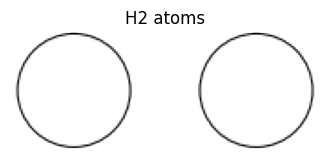

In [ ]:
view_ase_atoms(atoms, figsize=(4, 4), title="H2 atoms", scale=100)

Вместо элементарных символов атомные номера могут быть указаны как .symbolsnumbers

In [ ]:
co_atoms = Atoms(numbers=[6, 8], positions=[[0, 0, 0], [1.0, 0, 0]])
view_x3d(co_atoms)

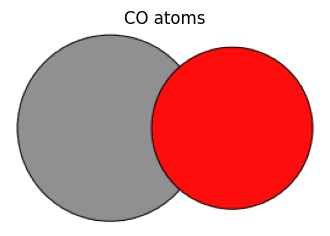

In [ ]:
view_ase_atoms(co_atoms, figsize=(4, 4), title="CO atoms", scale=100)

Если требуется определить систему с периодическими граничными условиями, можно указать периодическую информацию в параметре и включить или выключить применение периодических граничных условий для каждой из осей a, b и c в .cellpbc

In [ ]:
from ase import Atoms


na2_atoms = Atoms(
    symbols="Na2",
    positions=[[0, 0, 0], [2.115, 2.115, 2.115]],
    cell=[4.23, 4.23, 4.23],
    pbc=[True, True, True]
)

In [ ]:
view_x3d(na2_atoms)

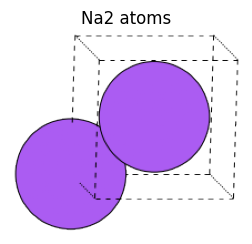

In [ ]:
view_ase_atoms(na2_atoms, rotation="10x,10y,0z", figsize=(3, 3), title="Na2 atoms", scale=30)

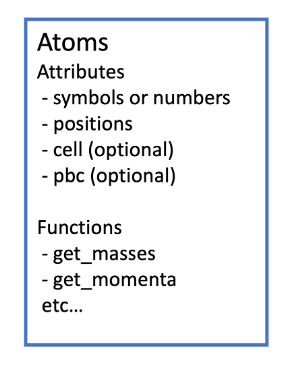

Он содержит информацию о структуре и может быть использован с помощью атрибутов и функций. Атрибуты — это переменные, которыми обладает класс, на некоторые из которых можно ссылаться напрямую как на .atomsget_XXXAtomsatoms.xxx

Доступ к некоторой информации можно получить с помощью методов. Ниже приведена сводка возвращаемых значений (как выглядит форма в виде массива numpy) основного атрибута и методов.

**Атрибуты**

- *symbols*: возвращает сводку по элементарным видам и их численности.

- *numbers*: массив атомных номеров, форма (N,).

- *positions*: координаты каждого атома, форма которого равна (N, 3), где 3 означает координаты xyz.

- *cell*: представлен классом ASE.Cell

- - Подробнее о классе Cell будет рассказано ниже. В общем случае он представлен матрицей векторов осей a, b и c соответственно, например, в триклинном кристалле. В некоторых случаях, таких как орторомбический кристалл, клетка может быть представлена вектором формы (3,), который представляет длину осей a, b и c.

- *pbc*: Указывает, существует ли периодическое граничное условие в каждом направлении.

**Методы**
- *get_masses()*: возвращает массу каждого атома.

- *get_momenta()*: возвращает импульс для каждого атома.

- *len(atoms)*: возвращает количество атомов в целом .Natoms

In [ ]:
print(f"symbols  : {atoms.symbols}")
print(f"positions: {atoms.positions}")
print(f"cell     : {atoms.cell}")
print(f"pbc      : {atoms.pbc}")

# "Atomic numbers" and "Mass" can be automatically calculated from "Symbol"
print(f"numbers  : {atoms.numbers}")
print(f"massess  : {atoms.get_masses()}")
print(f"momenta  : {atoms.get_momenta()}")
print(f"Numbers of atoms  : {len(atoms)}")

symbols  : H2
positions: [[0. 0. 0.]
 [1. 0. 0.]]
cell     : Cell([0.0, 0.0, 0.0])
pbc      : [False False False]
numbers  : [1 1]
massess  : [1.008 1.008]
momenta  : [[0. 0. 0.]
 [0. 0. 0.]]
Numbers of atoms  : 2


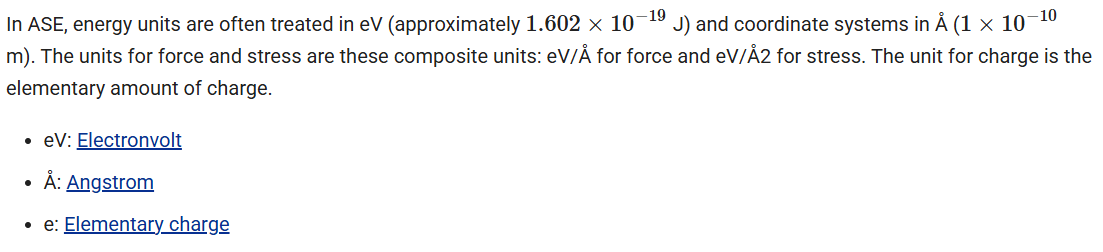

In [ ]:
Atoms?

## Structure Generation Methods

Координаты атомов мы непосредственно указывали в предыдущем разделе. Это хорошо, если вы хотите детально задать положение каждого атома, однако явная проверка и установка значений координат каждого атома обычно затруднена.

В ASE определены различные простые методы генерации структур.

https://wiki.fysik.dtu.dk/ase/ase/build/build.html

In [ ]:
from ase.build import molecule
from ase.collections import g2

print(f"Available molecule:", len(g2.names), g2.names)

Available molecule: 162 ['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '

In [ ]:
ch3cho_atoms = molecule("CH3CHO")
view_x3d(ch3cho_atoms)

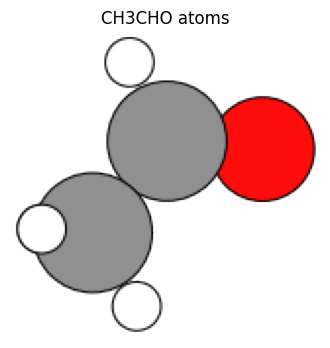

In [ ]:
view_ase_atoms(ch3cho_atoms, rotation="0x,0y,0z", figsize=(4, 4), title="CH3CHO atoms", scale=40)

### ASE bulk
Этот метод может быть использован для легкого создания кристаллических структур. Кристаллическая структура создается путем указания значений, характеризующих кристалл, как показано ниже

- **name**: Имя символа атома

- **crystalstructure**: Кристаллическая структура, такая как "sc", "fcc", "bcc" и т.д.

- **a, b, c, alpha, covera**: Укажите форму и размер ключа.

- **cubic**: Должна ли ячейка быть кубической элементарной ячейкой или нет.

In [ ]:
from ase.build import bulk

fe_sc_atoms = bulk(name="Fe", crystalstructure="sc", a=2.0)
fe_sc_atoms

Atoms(symbols='Fe', pbc=True, cell=[2.0, 2.0, 2.0])

В следующей визуализации показан только один атом. Если вы уменьшите масштаб и посмотрите на всю систему, вы увидите рамку, которая и является клеткой.

In [ ]:
view_x3d(fe_sc_atoms)

Имея ячейку и периодическое граничное условие (pbc), рассмотрим структуру, такую, что указанная структура продолжается бесконечно в соответствии с периодическим граничным условием. Другими словами, хотя на дисплее показан только один атом, он представляет собой кристаллическую структуру, в которой структуры расположены в регулярной последовательности, как в следующей структуре.

In [ ]:
view_x3d(fe_sc_atoms * (6, 6, 6))

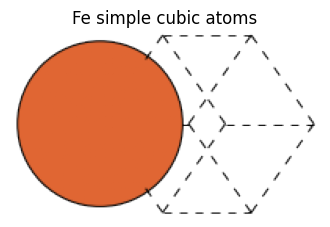

In [ ]:
view_ase_atoms(fe_sc_atoms, rotation="45x,45y,0z", figsize=(4, 4), title="Fe simple cubic atoms", scale=40)

If you do not specify `crystalstructure`, cell size `a`, etc., ASE will [automatically determine the best value based on the elemental species](https://gitlab.com/ase/ase/-/blob/6cb8784ac1056b7b897822ff7b763a323d92a543/ase/data/__init__.py#L578)。

For example, the Fe BCC structure is `a=2.87`.

In [ ]:
fe_atoms = bulk("Fe")
fe_atoms

Atoms(symbols='Fe', pbc=True, cell=[[-1.435, 1.435, 1.435], [1.435, -1.435, 1.435], [1.435, 1.435, -1.435]], initial_magmoms=...)

In [ ]:
view_x3d(fe_atoms)

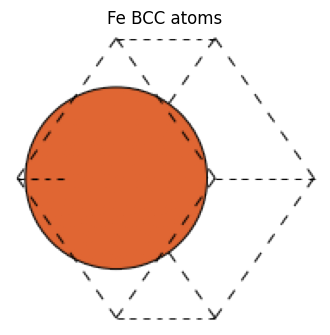

In [ ]:
view_ase_atoms(fe_atoms, rotation="45x,0y,0z", figsize=(4, 4), title="Fe BCC atoms", scale=40)

Как было показано выше, в структурах BCC и FCC примитивная ячейка, которая является элементарной ячейкой, содержащей только один атом, не является кубической, но ее можно сделать кубической, взяв расширенную элементарную ячейку. Атомы с кубической решеткой могут быть сгенерированы путем установки аргумента `cubic=True`. Разницу между этими примитивными ячейками и элементарными ячейками с кубическими ячейками можно найти в следующих ссылках.

https://www2.latech.edu/~pderosa/SS_2010/Supporting%20Documents/4p70chap1lect2b.pdf

In [ ]:
fe_cubic_atoms = bulk("Fe", cubic=True)
fe_cubic_atoms

Atoms(symbols='Fe2', pbc=True, cell=[2.87, 2.87, 2.87], initial_magmoms=...)

In [ ]:
view_x3d(fe_cubic_atoms)

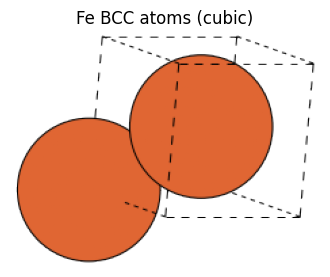

In [ ]:
view_ase_atoms(fe_cubic_atoms, rotation="10x,30y,0z", figsize=(4, 4), title="Fe BCC atoms (cubic)", scale=40)

### Repeat method

Структура с периодическими граничными условиями может быть превращена в суперячейку с помощью метода повторения структуры элементарной ячейки.repeat

В следующем примере создается атомная структура ячейки с размером 2x в направлении a, 3x в направлении b-axis и 4x в направлении c.

In [ ]:
fe234_atoms = fe_atoms.repeat((2, 3, 4))
view_x3d(fe234_atoms)

In [ ]:
fe234_atoms = fe_atoms * (2, 3, 4)
view_x3d(fe234_atoms)

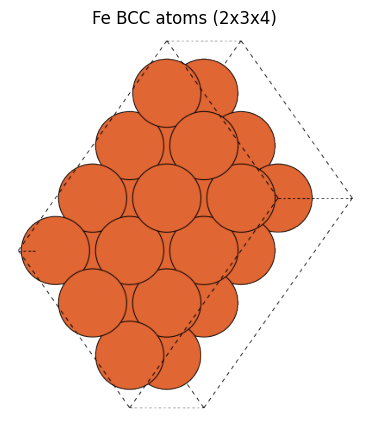

In [ ]:
view_ase_atoms(fe234_atoms, rotation="45x,0y,0z", figsize=(5, 5), title="Fe BCC atoms (2x3x4)", scale=30)

Учитывая, что элементарная ячейка бесконечно продолжается в соответствии с периодическим граничным условием, мы можем подтвердить, что структура Fe, представленная примитивной ячейкой без указания куба, и структура Fe элементарной ячейки с представляют одну и ту же структуру.cubic=True

Метод также позволяет создавать структуры, состоящие из двух элементов.

In [ ]:
nacl_atoms = bulk("NaCl", crystalstructure="rocksalt", a=2.0)
view_x3d(nacl_atoms * (3, 3, 3))

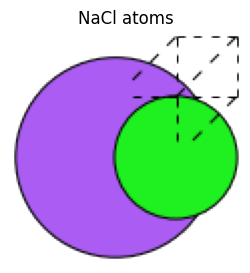

In [ ]:
view_ase_atoms(nacl_atoms, rotation="0x,0y,0z", figsize=(3, 3), title="NaCl atoms", scale=30)

### Slab: Surface structure

Когда мы имеем дело с реакциями с катализаторами, мы моделируем явления, глядя на то, как реагирующие вещества ведут себя по отношению к поверхности кристалла металла. Поверхность кристалла может быть задана индексом Миллера.

ASE может создать вырез каждой поверхности с заданным индексом Миллера для основных кристаллических структур. Поверхности создаются в направлении оси Z. Конструкция с такой поверхностью называется плитной конструкцией. При создании конструкции перекрытия указываются следующие параметры.

- **symbol**: Тип элемента атома.

- **size**: Количество атомов в каждом направлении осей x, y и z.

- **vacuum**: толщина вакуумного слоя, который должен быть создан выше и ниже оси z.

In [ ]:
from ase.build import (
    fcc100, fcc110, fcc111, fcc211, fcc111_root,
    bcc100, bcc110, bcc111, bcc111_root,
    hcp0001, hcp10m10, hcp0001_root,
    diamond100, diamond111
)

# fcc: fcc100(), fcc110(), fcc111(), fcc211(), fcc111_root()
# bcc: bcc100(), bcc110(), bcc111() * - bcc111_root()
# hcp: hcp0001(), hcp10m10(), hcp0001_root()
# diamond: diamond100(), diamond111()

pt100_atoms = fcc100("Pt", size=(4, 5, 6), vacuum=10.0)

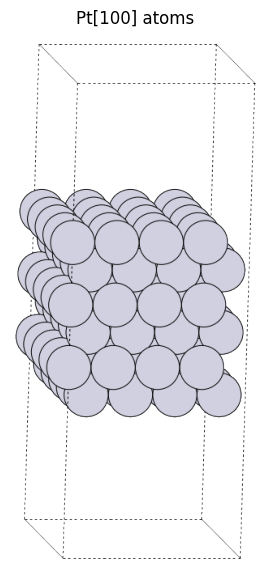

In [ ]:
view_ase_atoms(pt100_atoms, rotation="-80x,10y,0z", figsize=(7.0, 7.0), title="Pt[100] atoms", scale=20)

In [ ]:
fcc100?

### Structure generation from SMILES

https://ru.wikipedia.org/wiki/SMILES

Когда речь идет об органических молекулах, нотация SMILES часто используется для обозначения той или иной молекулы. Например, этилен может быть представлен как "С=С". Следующая функция использует RDKit, библиотеку, которая внутренне обрабатывает органические молекулы, для генерации атомов из SMILES.

In [ ]:
from ase.data.pubchem import pubchem_atoms_search

atoms = pubchem_atoms_search(smiles="C=C")
view_x3d(atoms)

### Чтение из файла

ASE поддерживает запись и чтение из файлов, описывающих различные атомарные структуры, такие как xyz, cif, VASP POSCAR файлы и т.д. Список поддерживаемых файлов приведен в следующем документе.

https://wiki.fysik.dtu.dk/ase/ase/io/io.html

In [ ]:
from ase.io import read, write

# write to file
write("output/pt100.xyz", pt100_atoms)

/usr/local/lib/python3.11/dist-packages/ase/io/extxyz.py:311: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [ ]:
# read from file
read("output/pt100.xyz")

Atoms(symbols='Pt120', pbc=[True, True, False], cell=[11.087434329005065, 13.85929291125633, 29.8], tags=...)

### Использование внешней базы данных
Также есть возможность загружать файлы и считывать структуры из больших баз данных, таких как

https://materialsproject.org/

https://next-gen.materialsproject.org/

PubChem: https://pubchem.ncbi.nlm.nih.gov/

## ASE Calculator  

В этом разделе мы научимся обращаться с , что необходимо для физического моделирования. (Calculator)

https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html

### Энергия
Полная энергия системы выражается в терминах кинетической и потенциальной энергии.

$$ E = K + V $$

Из них кинетическую энергию атомов можно рассчитать следующим образом, исходя из классической механики.

$$ K = \sum_{i=1}^{N} \frac{1}{2} m_i {\mathbf{v}}_i^2 = \sum_{i=1}^{N} \frac{{\mathbf{p}}_i^2}{2 m_i}  $$

where $m_i, \mathbf{v}_i, \mathbf{p}_i$ are the mass, velocity and momentum ($\mathbf{p}=m\mathbf{v}$) of each atom, respectively.

Those in bold represent vectors, where the velocity $\mathbf{v}$ and momentum $\mathbf{p}$ have three components in xyz coordinates.


С другой стороны, потенциальную энергию нелегко получить в точности, потому что для этого необходимо решать уравнения, выведенные из квантовой механики (например, уравнение Шредингера, см. колонку). Существуют различные методы определения потенциальной энергии, начиная от классических силовых полей, которые являются быстрыми, но ограниченными в своей применимости, и заканчивая квантово-химическими расчетами, такими как теория функционала плотности (DFT), которая занимает больше времени, но является более точной (различия между этими методами заключаются в следующем. обсуждается ниже).

Так почему же мы хотим знать об энергии в первую очередь? Другими словами, чему мы можем научиться у энергии?

Во-первых, мы можем знать стабильную структуру вещества, которая не является самоочевидной по своей природе (как объясняется в главе 2). Глядя на низкие и высокие энергии, мы можем проанализировать, реализована ли структура в природе или нет.

Во-вторых, мы можем узнать, как движется каждый атом. Об этом будет рассказано в следующем разделе.

### Силы
В классической механике уравнения движения Ньютона выражаются следующим образом

$$\mathbf{F} = m\mathbf{a}$$

Это уравнение показывает, что при заданной силе мы знаем ускорение, приложенное к системе.

Положение, скорость и ускорение каждого атома связаны следующим образом.

$$\mathbf{v} = \frac{d\mathbf{r}}{dt}$$
$$\mathbf{a} = \frac{d\mathbf{v}}{dt} = \frac{d^2\mathbf{r}}{dt^2}$$

Следовательно, когда мы знаем силу, мы знаем ускорение (= как изменяется скорость), и, как следствие, мы знаем, как положение меняется с течением времени. MD (Molecular Dynamics), которая на самом деле занимается эволюцией времени таким образом, рассматривается в главе 6.

Силы могут быть выражены как производная потенциальной энергии с возвратом к положениям.

$$\mathbf{F} = -\frac{\partial V}{\partial \mathbf{r}} $$

Таким образом, сила, необходимая для знания эволюции системы во времени, может быть рассчитана, если известна потенциальная энергия.

### Класс калькулятора
Мы объясняли, что как только потенциальная энергия определена, мы знаем управляющие уравнения системы, то есть то, как атомы движутся в этом мире.

В ASE класс Calculator отвечает за расчет потенциальной энергии, а метод расчета можно переключить, переключив Calculator.

Давайте рассмотрим один пример. Ниже приведен расчет каждой энергии H2 с помощью калькультора PFP, предоставленного Matlantis.

Подробное использование описано ниже, но вы можете рассчитать каждую энергию, установив Калькулятор. В этом примере мы используем следующие методы для вычисления каждой энергии.atoms.calc

- Общая энергия : E
atoms.get_total_energy()

- Потенциальная энергия : V
atoms.get_potential_energy()

- Кинетическая энергия: K
atoms.get_kinetic_energy()

In [ ]:
from ase import Atoms
from ase.calculators.lj import LennardJones

calculator = LennardJones()

In [ ]:
atoms = Atoms("H2", [[0, 0, 0], [1.0, 0, 0]])
atoms.set_momenta([[0.1, 0, 0], [-0.1, 0, 0]])
atoms.calc = calculator

E_tot = atoms.get_total_energy()
E_pot = atoms.get_potential_energy()
E_kin = atoms.get_kinetic_energy()

print(f"Total Energy     : {E_tot:f} eV")
print(f"Kinetic Energy   : {E_kin:f} eV")
print(f"Potential Energy : {E_pot:f} eV")

Total Energy     : 0.015400 eV
Kinetic Energy   : 0.009921 eV
Potential Energy : 0.005479 eV


Атомы изначально имеют начальную скорость 0 и кинетическую энергию 0, поэтому соответствующая начальная скорость задается с помощью функции.set_momenta

Вы можете видеть, что $ E = K + V $.

Калькулятор необходим для расчета общей энергии и потенциальной энергии, а без настройки `atoms.calc = calculator` расчет не может быть выполнен и будет выдана ошибка.

ASE поддерживает множество калькуляторов, от классических силовых полей до калькуляторов, использующих квантовые математические вычисления. Некоторые примеры приведены ниже.

<table>
  <tr>
    <th>Category</th>
    <th>Calculator</th>
    <th>ASE embedded</th>
    <th>Description</th>
  </tr>
  <tr>
    <td rowspan="4">Classical force field</td>
    <td>lj</td>
    <td>✓</td>
    <td>Lennard-Jones potential</td>
  </tr>
  <tr>
    <td>morse</td>
    <td>✓</td>
    <td>Morse potential</td>
  </tr>
  <tr>
    <td>emt</td>
    <td>✓</td>
    <td>Effective Medium Theory calculator</td>
  </tr>
  <tr>
    <td>lammps</td>
    <td></td>
    <td>Classical molecular dynamics code</td>
  </tr>
  <tr>
    <td rowspan="3">Quantum chemical calculations</td>
    <td>gaussian</td>
    <td></td>
    <td>Gaussian based electronic structure code</td>
  </tr>
  <tr>
    <td>vasp</td>
    <td></td>
    <td>Plane-wave PAW code</td>
  </tr>
  <tr>
    <td>espresso</td>
    <td></td>
    <td>Plane-wave pseudopotential code</td>
  </tr>
  <tr>
    <td rowspan="１">NNP (Neural Network Potential)</td>
      <td><b>PFP</b></td>
    <td></td>
      <td>Potential provided by <a href="https://matlantis.com/">Matlantis</a></td>
  </tr>
</table>

Вычислители, относящиеся к классическим силовым полям, представляют собой методы, рассчитывающие потенциалы с использованием вручную созданных (эмпирических) формул функций, например, потенциал Леннарда-Джонса, потенциал Морзе. Скорость вычислений высокая, но каждый метод может работать с различными структурами и физическими явлениями.

В библиотеке ASE атомная структура представлена классом Atoms, и каждое основное значение физического свойства (энергия, сила, напряжение, заряд и т.д.) для Atoms можно рассчитать, установив для него Calculator. Калькулятор устанавливается непосредственно в положение

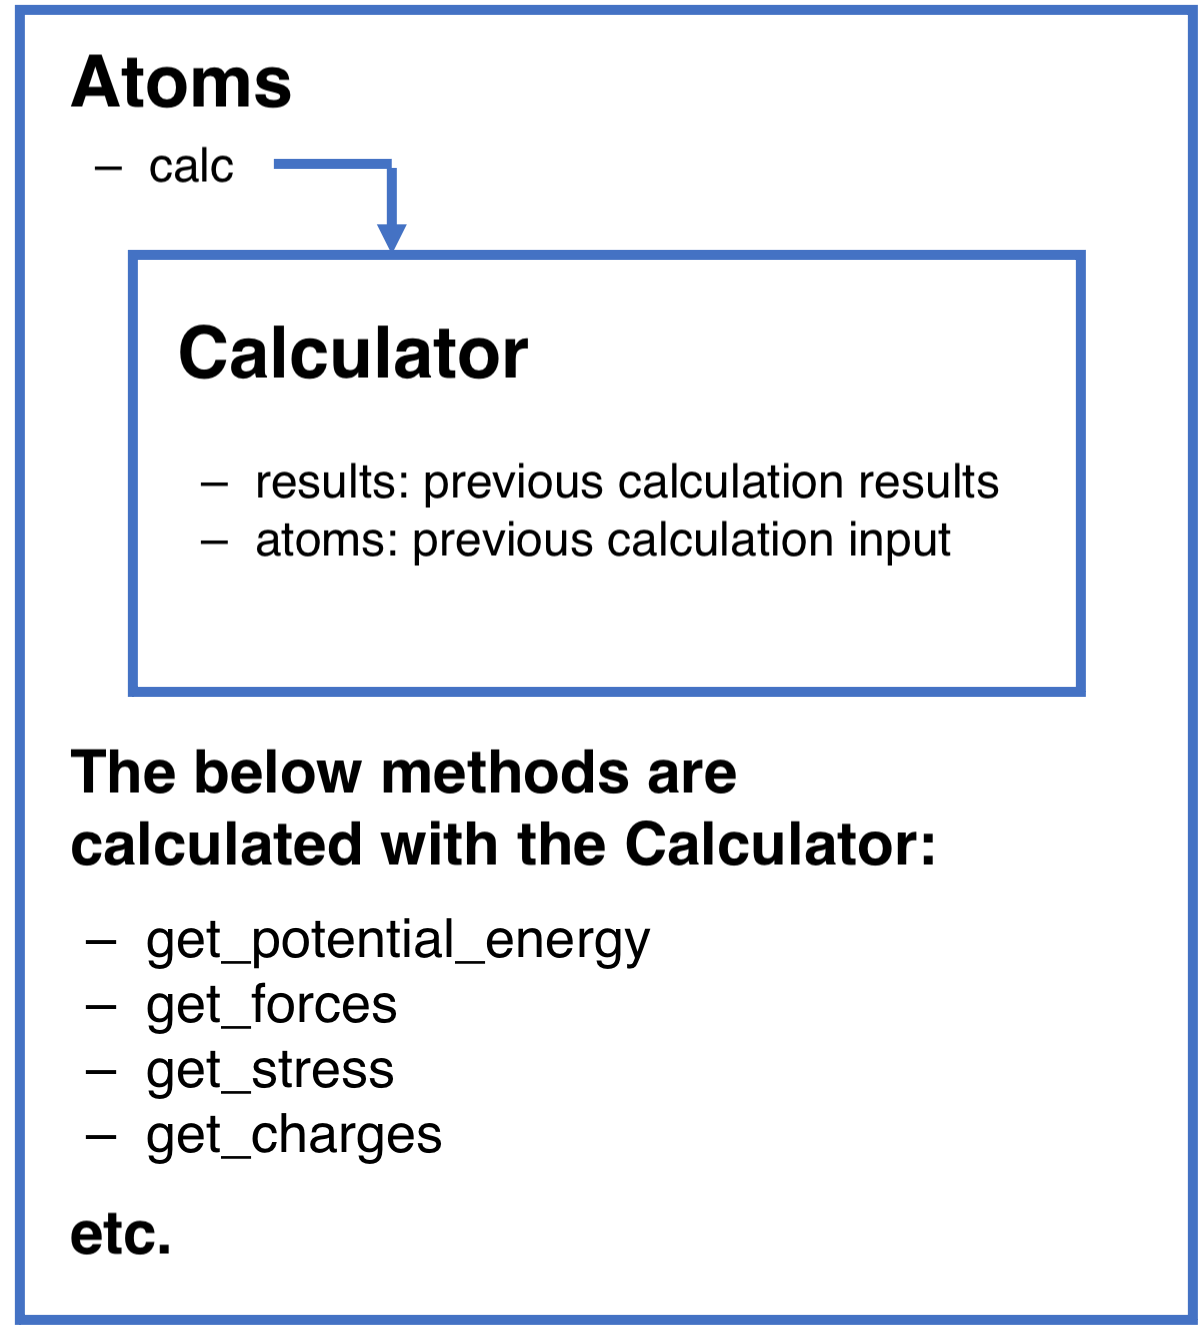

Что можно расчитать:
 - Potential energy: `get_potential_energy`
 - Force: `get_forces`
 - Stress: `get_stress`
 - Charge: `get_charges`
 - Magnetic moment: `get_magnetic_moment`
 - Dipole moment: `get_dipole_moment`

In [ ]:
from ase.build import bulk

atoms = bulk("Pt") * (2, 2, 1)
atoms.calc = calculator

E_pot = atoms.get_potential_energy()
forces = atoms.get_forces()
stress = atoms.get_stress()

print(f"E_pot {E_pot:.2} eV")
print(f"forces {forces} eV/A")
print(f"stress {stress} eV/A^2")

E_pot -0.08 eV
forces [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.46944695e-18  0.00000000e+00]
 [ 0.00000000e+00 -3.46944695e-18  0.00000000e+00]
 [-3.46944695e-18  0.00000000e+00  0.00000000e+00]] eV/A
stress [6.99676509e-03 6.99676509e-03 6.99676509e-03 1.05046331e-20
 1.05046331e-20 0.00000000e+00] eV/A^2


## Atoms playground

### Копирование

После создания `атомов` вы можете использовать метод `copy()`, чтобы сделать их копию. <br/>
Копируются элементарные виды и координаты атомов, а также ячейки.

В дальнейшем `atoms2` — это копия H2O с теми же значениями координат, что и у атомов.

In [ ]:
from ase.build import molecule, bulk
atoms = molecule("H2O")
atoms2 = atoms.copy()

print("atoms :", atoms)
print("pos", atoms.positions)
print()
print("atoms2:", atoms2)
print("pos", atoms2.positions)

atoms : Atoms(symbols='OH2', pbc=False)
pos [[ 0.        0.        0.119262]
 [ 0.        0.763239 -0.477047]
 [ 0.       -0.763239 -0.477047]]

atoms2: Atoms(symbols='OH2', pbc=False)
pos [[ 0.        0.        0.119262]
 [ 0.        0.763239 -0.477047]
 [ 0.       -0.763239 -0.477047]]


### Изменение свойств

У Atoms есть различные методы get и set.
Мы можем изменять значения атрибутов Atoms с помощью этих методов.

- https://wiki.fysik.dtu.dk/ase/ase/atoms.html#working-with-the-array-methods-of-atoms-objects

Например, в предыдущем разделе для задания импульса каждого атома использовался метод `set_momenta`.

### Изменение значений координат

В случае изменения значений координат можно напрямую переписать `atoms.positions`.

In [ ]:
atoms = molecule("CH3CHO")
atoms.positions

array([[ 1.218055,  0.36124 ,  0.      ],
       [ 0.      ,  0.464133,  0.      ],
       [-0.477241,  1.465295,  0.      ],
       [-0.948102, -0.700138,  0.      ],
       [-0.385946, -1.634236,  0.      ],
       [-1.596321, -0.652475,  0.880946],
       [-1.596321, -0.652475, -0.880946]])

In [ ]:
view_x3d(atoms)

Давайте переместим 0-й атом O из [1.218055, 0.36124, 0.] в [2.0, 0, 0].

Вы можете переназначить напрямую - atoms.positions

In [ ]:
# First axis 0 specifies atom index = O
# Second axis with the value 0,1,2 corrensponds to x, y, z axis respectively.
atoms.positions[0] = [2.0, 0, 0]

In [ ]:
view_x3d(atoms)

### Перевод и вращение

Перевод и вращение целых атомов можно выполнить с помощью методов `translate` и `rotate`. Метод `translate` переводит все молекулы на одинаковую величину, учитывая вектор (3,) xyz, и переводит n атомов на отдельные величины, учитывая вектор (n, 3).
<br/>

Следующий пример смещает все атомы на [1.0, 0, 0]. <br/>

Если вы проверите значения координат, то увидите, что они смещаются только в направлении оси x.

In [ ]:
atoms.translate([1.0, 0, 0])
atoms.positions

array([[ 3.      ,  0.      ,  0.      ],
       [ 1.      ,  0.464133,  0.      ],
       [ 0.522759,  1.465295,  0.      ],
       [ 0.051898, -0.700138,  0.      ],
       [ 0.614054, -1.634236,  0.      ],
       [-0.596321, -0.652475,  0.880946],
       [-0.596321, -0.652475, -0.880946]])

Метод `rotate` используется для вращения атомов.

В следующем примере атомы поворачиваются на 90° вдоль оси z. <br/>
Ось вращения также может быть указана как вектор, например `v=[0,0,1]`.

In [ ]:
atoms.rotate(90, v="z")
atoms.positions

array([[ 1.8369702e-16,  3.0000000e+00,  0.0000000e+00],
       [-4.6413300e-01,  1.0000000e+00,  0.0000000e+00],
       [-1.4652950e+00,  5.2275900e-01,  0.0000000e+00],
       [ 7.0013800e-01,  5.1898000e-02,  0.0000000e+00],
       [ 1.6342360e+00,  6.1405400e-01,  0.0000000e+00],
       [ 6.5247500e-01, -5.9632100e-01,  8.8094600e-01],
       [ 6.5247500e-01, -5.9632100e-01, -8.8094600e-01]])

In [ ]:
view_x3d(atoms)

При вращении системы с периодической структурой, как показано ниже, ячейка остается неизменной, а вращаются только координаты атомов, поэтому атомы оказываются вне ячейки.

In [ ]:
atoms = bulk("Fe") * (2, 3, 4)

atoms.rotate(90, v=[0, 0, 1])
view_x3d(atoms)

Чтобы одновременно повернуть координаты ячейки, используйте `rotate_cell=True`.

In [ ]:
atoms = bulk("Fe") * (2, 3, 4)

atoms.rotate(90, v=[0, 0, 1], rotate_cell=True)
view_x3d(atoms)

## Случайное перемещение

Метод `rattle` можно использовать для создания слегка беспорядочной структуры, случайным образом перемещая каждый атом.

В этом примере мы сначала создаем кристалл Si.

In [ ]:
atoms = bulk("Si") * (2, 3, 4)
view_x3d(atoms)

Давайте немного нарушим структуру этой системы с помощью `rattle`.
Направление смещения можно изменить, изменив спецификацию семян.

In [ ]:
atoms.rattle(stdev=0.2, seed=1)
view_x3d(atoms)

Его также можно изменить в большей степени, изменив значение `stdev`.

In [ ]:
atoms.rattle(stdev=0.5)
view_x3d(atoms)

[Примечание] Если аргумент seed метода `rattle` в ASE не указан, используется **`seed=42`, а результат rattle является детерминированным**.

В следующем примере результаты двух вызовов `rattle` одинаковы.

In [ ]:
import numpy as np


atoms = bulk("Si") * (2, 3, 4)
atoms2 = atoms.copy()

atoms.rattle(stdev=0.2)
atoms2.rattle(stdev=0.2)

print("atoms & atoms2 positions are same? --> ", np.allclose(atoms.positions, atoms2.positions))

atoms & atoms2 positions are same? -->  True


Если вы хотите каждый раз получать другой случайный результат, укажите `rng=np.random.RandomState()`.

In [ ]:
atoms = bulk("Si") * (2, 3, 4)
atoms2 = atoms.copy()

atoms.rattle(stdev=0.2, rng=np.random.RandomState())
atoms2.rattle(stdev=0.2, rng=np.random.RandomState())

print("atoms & atoms2 positions are same? --> ", np.allclose(atoms.positions, atoms2.positions))

atoms & atoms2 positions are same? -->  False


## Wrap

Если атом был перемещен за пределы ячейки, как в кристалле Si выше, его можно вернуть обратно в соответствующую периодическую структуру, используя функцию `wrap`.

In [ ]:
atoms.wrap()
view_x3d(atoms)

## Двухатомный потенциал

Энергия двухатомного потенциала (потенциал двух тел) — это энергия взаимодействия, когда в вакуум помещены только два атома. Значение зависит от расстояния между атомами.

### Рассчитайте двухатомную потенциальную энергию молекулы водорода

Используя то, что мы узнали до сих пор, давайте вычислим двухатомную потенциальную энергию молекулы водорода.

Давайте сгенерируем молекулы водорода с различными расстояниями между атомами водорода, вычислим их энергии и построим графики.

In [ ]:
from ase.calculators.emt import EMT

calculator = EMT()

In [ ]:
import numpy as np
from tqdm.auto import tqdm
from ase import Atoms

distances = np.linspace(0.3, 6.5, 100)
energy_list = []
for d in tqdm(distances):
    atoms = Atoms("H2", [[0, 0, 0], [0, 0, d]])
    atoms.calc = calculator
    E_pot = atoms.get_potential_energy()
    energy_list.append(E_pot)

energies = np.array(energy_list)

  0%|          | 0/100 [00:00<?, ?it/s]

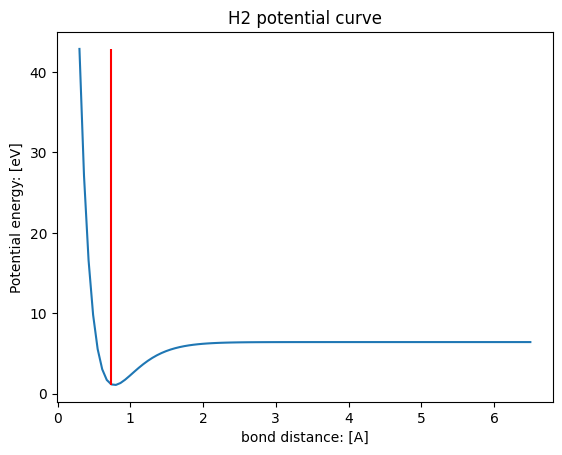

In [ ]:
import matplotlib.pyplot as plt


plt.plot(distances, energies)
# H2 bond length = 0.74A
plt.vlines(0.74, np.min(energies), np.max(energies), color="red")
plt.xlabel("bond distance: [A]")
plt.ylabel("Potential energy: [eV]")
plt.title("H2 potential curve")
plt.show()

In [ ]:
distances[np.argmin(energies)]

np.float64(0.801010101010101)

Видно, что энергия молекулы водорода, состоящей из тех же двух атомов водорода, сильно отличается только за счет изменения межатомного расстояния. <br/>
Экспериментально известно, что молекулы водорода наиболее стабильны при длине связи 0,74 А.
Самые низкие энергии получаются в самых близких положениях при расчетах ЭМП.

Таким образом, можно проанализировать, как структурированы материалы в природе, вычисляя энергии для различных структур.

## Структурная оптимизация

В этой главе мы узнаем о **структурной оптимизации** (также называемой структурной релаксацией, структурной оптимизацией или структурной релаксацией), которая вычисляет локальные координаты устойчивости системы и ее энергию.

Существует два типа алгоритмов оптимизации: глобальная оптимизация и локальная оптимизация. В этой главе мы сосредоточим внимание на локальных методах оптимизации для структурной оптимизации.


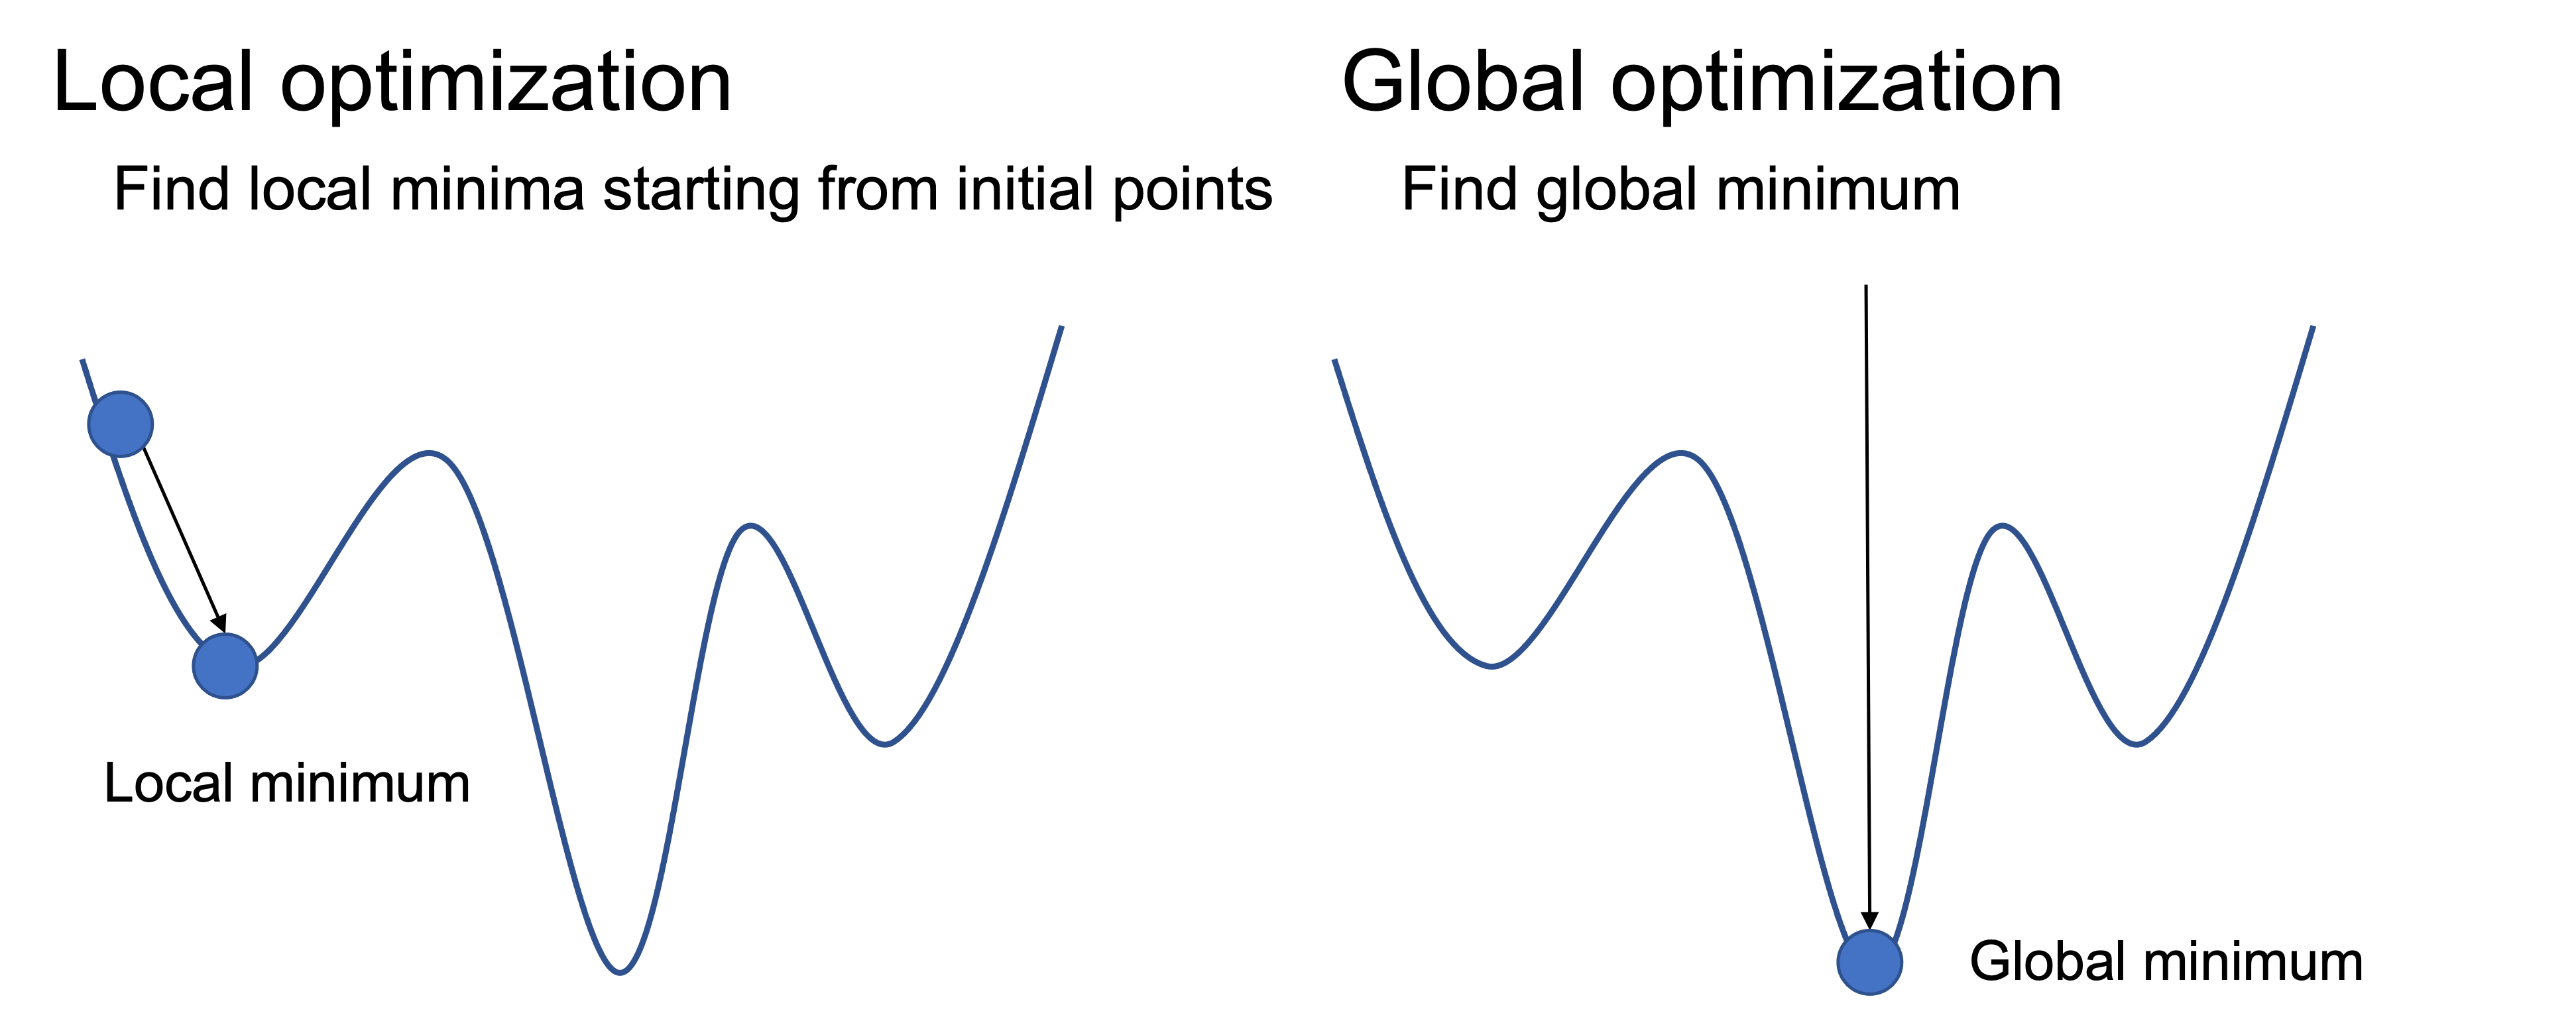

Координаты системы, состоящей из N атомов, имеют $3*N$ измерений свободы, например, система, состоящая из 100 атомов, представляет собой задачу оптимизации в многомерном пространстве с 300 измерениями. <br/>
Нахождение глобально оптимального решения, как правило, является сложной задачей.

Структурная оптимизация находит стабильную структуру системы, определяя начальные координаты системы и находя оттуда локальные стабильные точки. <br/>
Даже когда известен состав вещества (комбинация элементов и их пропорции, например, NaCl), не очевидно, какова его структура.
Определение стабильной структуры имеет важное значение, поскольку многие свойства вещества определяются из его состояния вблизи стабильной структуры.

Для экспериментального определения структуры могут использоваться следующие аналитические и измерительные приборы.

Однако даже в этом случае

- Из спектральной информации можно получить только частичную информацию о материале, а информацию о трехмерной структуре нельзя наблюдать напрямую (1~6)
- Необходимо подготовить такие структуры, как монокристаллы или тонкие пленки, и иногда бывает трудно подготовить такие образцы в реальности (3, 8)
- Недостаточное разрешение для наблюдения в атомном масштабе (7)
- Хотя форму поверхности можно наблюдать, невозможно различить тип атомов и молекул (9)

Нелегко определить, как каждый атом расположен в материале, с которым мы имеем дело, и идентифицировать трехмерную структуру материала.

Примеры аналитических приборов:

| Name | Description |
|:---|:---|
|1. Infrared spectroscopy |Obtain information on molecular structure by measuring infrared absorption due to molecular vibrations. |
|2. Raman spectroscopy |Raman scattering light is used to evaluate materials. |
|3. XRD: X-ray Diffraction |Identification and quantification of substances by analyzing diffraction obtained by a beam of incident X-rays to crystal structures. |
|4. XPS: X-ray Photoelectron Spectroscopy |X-rays are irradiated to a material, and the photoelectrons e- emitted as a result of ionization of the material are measured for energy analysis. |
|5. MS: Mass Spectroscopy |Accurately measures the mass of individual compounds that make up a substance. |
|6. NMR: Nuclear Magnetic Resonance | Analyze organic compounds using the phenomenon of nuclear resonance. |
|7. SEM: Scanning Electron Microscope | Observation of surfaces with a resolution of 0.4~4nm using electron beams with short wavelengths. |
|8. TEM: Transmission Electron Microscope | Observation of microscopic substances by the intensity of the electron beam transmitted through the object. |
|9. AFM: Atomic Force Microscope | Microscope to detect the atomic forces acting between the tip and the sample. |


Поэтому крайне важно оценить, какая структура вероятнее всего будет присутствовать в моделировании, и проверить ее в эксперименте (или наоборот).

### Циклогексан

В качестве следующего примера рассмотрим стабильную структуру циклогексана.

Циклогексан имеет структуру $C_6H_{12}$, но, как известно, принимает несколько конформаций. <br/>
Типичные конформационные изомеры включают кресло (A), твист-лодку (B), лодку (C) и полукресло (D), как показано на рисунке ниже.

Конформация кресла является наиболее стабильной (самая низкая энергия); при 25 °C 99,99% всех молекул в растворе циклогексана находятся в этой конформации. <br/>
В этом разделе мы подготовим исходные структуры формы кресла (A) и формы лодки (C), выполним структурную оптимизацию и сравним их формы и потенциальные энергии.

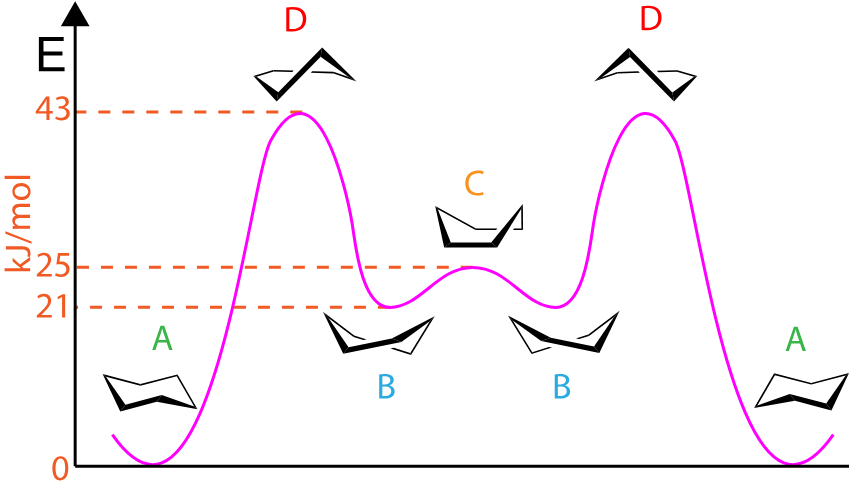

Cite from [cyclohexane conformation](https://en.wikipedia.org/wiki/Cyclohexane_conformation)</cite>

**Подготовим исходную координатную структуру**

Форма кресла подготовлена ​​на основе структуры, опубликованной в PubChem.

Изображение 3D-структуры CID 8078 Циклогексан (соединение)
PubChem Identifier: CID 8078<br/>
URL: https://pubchem.ncbi.nlm.nih.gov/compound/8078#section=3D-Conformer

In [ ]:
from ase.data.pubchem import pubchem_atoms_search

chair_atoms = pubchem_atoms_search(smiles="C1CCCCC1")
view_x3d(chair_atoms)

В этом уроке давайте сгенерируем форму лодки, вручную изменив значения координат из формы стула.

Вы можете пропустить понимание кода, даже если не знаете, что он делает. (Мы создаем атомы, повернутыми на 180 градусов, и только атомы 2, 10 и 11 перезаписываются повернутыми координатами.)

In [ ]:
boat_atoms = chair_atoms.copy()
axis = boat_atoms.positions[[1, 5]].mean(axis=0) - boat_atoms.positions[[0, 4]].mean(axis=0)
boat_atoms.rotate(180, axis)
# inds = [1, 3, 5, 8, 9, 12, 13, 16, 17]
inds = [2, 10, 11]
boat_atoms.positions[inds] = chair_atoms.positions[inds]

In [ ]:
view_x3d(boat_atoms)

In [ ]:
!wget https://openmopac.net/MOPAC2016.tar.gz
!tar -xzf MOPAC2016.tar.gz
!export PATH=$PATH:/content/MOPAC2016

--2025-05-08 14:10:04--  https://openmopac.net/MOPAC2016.tar.gz
Resolving openmopac.net (openmopac.net)... 50.63.8.167
Connecting to openmopac.net (openmopac.net)|50.63.8.167|:443... connected.
Unable to establish SSL connection.
tar (child): MOPAC2016.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
from ase.calculators.mopac import MOPAC
from ase.optimize import LBFGS
import os

# Убедитесь, что директория для вывода существует
os.makedirs("output", exist_ok=True)

# 1. Явно укажите путь к MOPAC (если нужно)
# os.environ['MOPAC_COMMAND'] = '/usr/local/bin/mopac'

# 2. Создаем калькулятор с дополнительными параметрами
calculator = MOPAC(
    label='ch-chair',
    method='PM7',
    task='1SCF GRADIENTS',
    command='mopac PREFIX.mop > PREFIX.out 2>&1'  # Явное указание команды
)

chair_atoms.calc = calculator

# 3. Добавляем параметры для оптимизации
opt = LBFGS(
    chair_atoms,
    trajectory="output/lbfgs_cyclohexane_chair.traj",
    restart="output/lbfgs_restart.pkl"
)
opt.run(fmax=0.05)  # Критерий сходимости (сила в eV/Å)

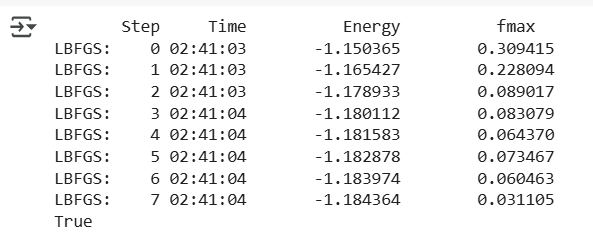

In [ ]:
calculator = MOPAC(label='ch-boat',  # 出力ファイルのベース名
                   method='PM7',  # 使用するMOPACのキーワード
                   task='1SCF GRADIENTS')  # 実行するタスク

boat_atoms.calc = calculator
opt = LBFGS(boat_atoms, trajectory="output/lbfgs_cyclohexane_boat.traj")
opt.run()

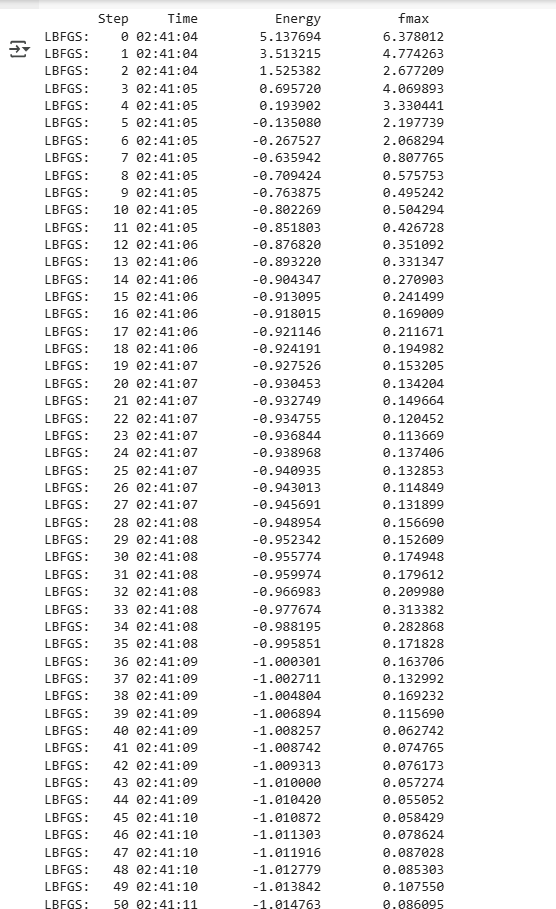

In [ ]:
view_x3d(chair_atoms)

In [ ]:
view_x3d(boat_atoms)

In [ ]:
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal

E_chair = chair_atoms.get_potential_energy()
E_boat = boat_atoms.get_potential_energy()

E_diff = E_boat - E_chair

print(f"E_chair {E_chair:.2f} eV")
print(f"E_boat  {E_boat:.2f} eV")
print(f"E_diff  {E_diff:.2f} eV = {E_diff / (kJ/mol):.2f} kJ/mol")

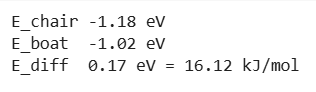

Форма кресла оказалась менее энергоемкой и более стабильной, чем форма лодки. <br/>
Разница в энергии также была близка к значению 25 кДж/моль, показанному на рисунке выше.

Таким образом, при структурной оптимизации начальная структура важна для нахождения локальной точки устойчивости. <br/>
Даже для одного и того же циклогексана результаты после структурной оптимизации будут отличаться в зависимости от того, как подготовлена ​​начальная структура.

### Кристалл кремния

Давайте рассмотрим, какая структура наиболее стабильна в качестве кристаллической структуры Si. В качестве кандидатов на кристаллические структуры мы пробуем следующие структуры.

- sc: Простой кубический

- bcc: Центрированный по корпусу кубический

- fcc: Грань центрированный кубический

- hcp: Шестиугольный плотно упакованный

- алмаз: Структура алмаза

Рассчитываем энергию на атом.

Во-первых, в следующем коде вычисляется потенциальная энергия и плотность для различных значений постоянной решетки для структуры Si BCC.a

Здесь метод используется для генерации пяти констант решетки в диапазоне от 2,5 А до 7,0 А, и вычисляется энергия в каждой постоянной решетки.np.linspacea

Пример: https://docs.matlantis.com/atomistic-simulation-tutorial/en/2_1_opt.html

### Оптимизация постоянной решетки кристалла Cu

Далее давайте эффективно найдем эту постоянную решетки, используя алгоритм структурной оптимизации.
При оптимизации объема с периодической структурой метод отличается в зависимости от того, оптимизируем ли мы только атомные координаты или **включая размер ячейки**. <br/>
Если вы хотите оптимизировать и ячейку, вам необходимо применить следующий класс фильтра к атомам ASE.

**Table: Optimization target and Filter to be used**

|  Position  | Cell | Filter |
| ---- | ---- | ---- |
|  ✓  |    | No filter (Default behavior) |
|    |  ✓  | `StrainFilter` |
|  ✓  |  ✓  | `ExpCellFilter` or `UnitCellFilter` |

1. Fix atomic coordinates, opt only cell --> `StrainFilter`
2. Fix cell, opt only atomic coordinates --> No Filter
3. Opt both atomic coordinates and cell  --> `ExpCellFilter`


Вот пример использования `StrainFilter`.

Мы оптимизируем постоянные решетки структур BCC и FCC атомов Cu. <br/>
Поскольку структуры BCC и FCC содержат только один атом в примитивной ячейке, оптимизация атомных координат не нужна, и достаточно оптимизировать только постоянные решетки.
Поэтому `StrainFilter` подходит.

In [ ]:
from ase.filters import StrainFilter
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.optimize import LBFGS
import os

# Create output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

# Create BCC copper structure (note: Cu is normally FCC at room temperature!)
cu_bcc_atoms = bulk("Cu", "bcc", a=3.0)  # Forced BCC structure with lattice parameter 3.0 Å
print("Initial cell parameters:", cu_bcc_atoms.cell)

# Assign EMT calculator (simple empirical potential)
cu_bcc_atoms.calc = EMT()

# Apply strain filter to optimize cell parameters
strain_filter = StrainFilter(cu_bcc_atoms)  # Filters out rigid rotations during optimization

# Set up LBFGS optimizer with trajectory logging
opt = LBFGS(strain_filter, trajectory="output/lbfgs_cu_bcc.traj")

# Run optimization with convergence criteria
opt.run(fmax=0.05)  # Maximum force tolerance (eV/Å)

print("Optimized cell parameters:", cu_bcc_atoms.cell)

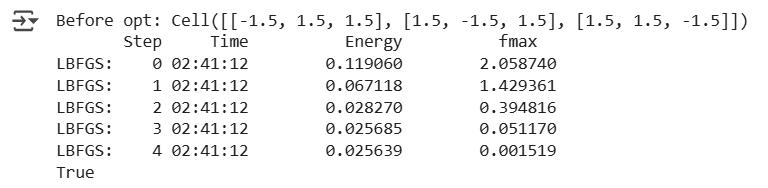

In [ ]:
cu_fcc_atoms = bulk("Cu", "fcc", a=3.0)
print("Before opt:", cu_fcc_atoms.cell)
cu_fcc_atoms.calc = EMT()

cu_fcc_atoms = StrainFilter(cu_fcc_atoms)
opt = LBFGS(cu_fcc_atoms, trajectory="output/lbfgs_cu_fcc.traj")
opt.run()

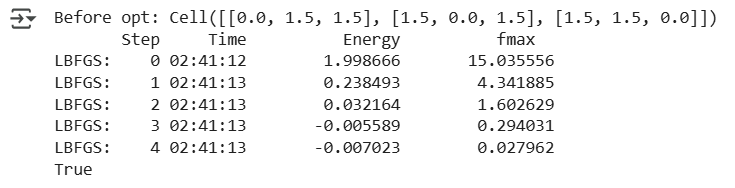

In [ ]:
cu_bcc_atoms.cell

Cell([[-1.5, 1.5, 1.5], [1.5, -1.5, 1.5], [1.5, 1.5, -1.5]])

In [ ]:
cu_fcc_atoms.atoms.cell

Cell([[0.0, 1.5, 1.5], [1.5, 0.0, 1.5], [1.5, 1.5, 0.0]])

При оптимизации констант решетки с использованием `StrainFilter` значения осей a, b и c немного отличаются из-за отсутствия учета симметрии кристалла. <br/>
(На самом деле, можно оптимизировать, сохраняя симметрию, используя `ExpCellFilter` или `FixSymmetry`, как описано ниже.)

Здесь мы возьмем среднее значение для расчета окончательной константы решетки. <br/>
Для аргумента `a` метода `bulk` ASE ячейки структуры BCC



```
[[-a/2, a/2, a/2],
 [a/2, -a/2, a/2],
 [a/2, a/2, -a/2]]
```

The cells of the FCC structure are

```
[[0, a/2, a/2],
 [a/2, 0, a/2],
 [a/2, a/2, 0]]
```

In [ ]:
a = np.abs(cu_bcc_atoms.cell).mean() * 2
E_pot = cu_bcc_atoms.get_potential_energy()
print(f"BCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

a = cu_fcc_atoms.atoms.cell.sum() / 3
E_pot = cu_fcc_atoms.get_potential_energy()
print(f"FCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

BCC opt: a = 3.00 A, E = 0.12 eV
FCC opt: a = 3.00 A, E = 2.00 eV


В результате структурной оптимизации мы обнаружили, что структура FCC имеет минимальную энергию при `a=3,59` A.

Мы также обнаружили, что **Cu более стабилен в структуре FCC, чем в структуре BCC**, что согласуется с экспериментальными результатами.

Одним из недостатков использования `StrainFilter` является то, что оси a, b и c ячейки оптимизируются независимо, поэтому даже если вы хотите сохранить это соотношение, оно может не сохраниться.

**[Примечание] Структурная оптимизация требуется каждый раз, когда изменяется Калькулятор (потенциальная энергия)**

Вы можете подумать, что структура на Materials project уже является совершенно стабильной структурой, поскольку это также структура, прошедшая структурную оптимизацию.
Однако точная локальная точка (структура, которая принимает наименьшую энергию) отличается при изменении потенциальной энергии.

### Структурная оптимизация и реальный мир

Расчеты структурной оптимизации, представленные в этой главе, являются основой почти для всех атомистических симуляций, представленных далее. Однако вычислительные методы, используемые внутри структурной оптимизации, несколько техничны, и новички в атомистических симуляциях в этом руководстве могут не понимать интуитивно необходимость таких расчетов. Поэтому в этой колонке мы рассмотрим расчеты структурной оптимизации с точки зрения их соответствия реальному миру.

### Необходимость структурной оптимизации

Учитывая, как определяется атомное расположение материала в реальном мире, каждый атом может свободно перемещаться без каких-либо особых ограничений, поэтому избыточная энергия рассеивается и преобразуется в стабильную структуру с низкой энергией.
Если мы рассмотрим случай, когда температура достаточно низкая, игнорируя влияние температуры, в этом случае кинетическая энергия атомов будет равна нулю, а потенциальная энергия будет минимальной.
В этом смысле расчеты структурной оптимизации соответствуют условиям абсолютной нулевой температуры в реальном мире.

А как насчет случая конечной температуры?
Из теории статистической механики известно, что температура и кинетическая энергия имеют постоянное соотношение в системе, находящейся в равновесии. Грубый расчет показывает, что повышение на 1 К соответствует примерно увеличению кинетической энергии на 1/10000 эВ/атом.
И наоборот, повышение энергии на 1 эВ/атом соответствует структуре примерно в 10000 К с точки зрения температуры.
Таким образом, даже при конечных температурах оптимизированная по энергии структура часто является достаточно хорошим приближением, поэтому общепринятой практикой является начало моделирования с расчета структурной оптимизации (а затем повышение температуры для конечных температур).

Моделирование без структурной оптимизации может привести к нереалистичным результатам из-за различий в предположениях.
Например, если размер ячейки кристаллической структуры железа уменьшить на 1%, вы можете не заметить никаких особых изменений, если будете только визуализировать атомную структуру.
Однако, как можно увидеть, рассмотрев операцию сжатия железа на 1% в реальном мире, это соответствует железу под высокой сжимающей силой (в частности, давлением, превышающим 1 ГПа), что может изменить результаты моделирования.

### Методы структурной оптимизации и реальная структурная релаксация

Давайте рассмотрим, почему существует несколько методов структурной оптимизации по их соответствию реальному миру. Что происходит, когда материал при достаточно высокой температуре, например, расплавленное железо, слегка охлаждается путем удаления тепла? Атомы железа постоянно вибрируют из-за тепла, принимая различные атомные конфигурации и постепенно переходя в структуру с более низкой потенциальной энергией. В конечном итоге они переходят в кристаллическую структуру с низкой энергией, хорошо упорядоченное расположение атомов. В этом смысле структурная оптимизация в реальном мире считается [имитацией отжига](https://en.wikipedia.org/wiki/Simulated_annealing)).
(Исторически это соответствует первоначальной идее отжига.)

При имитации отжига атомы находятся в движении в течение длительного времени при повышенной температуре. Это означает, что, в принципе, атомистическое моделирование может дать ту же стабильную структуру, что и в реальном мире, если можно выполнить достаточно длительный расчет молекулярной динамики.

Проблема здесь, однако, заключается в разрыве между временной шкалой моделирования МД и реальностью.
В то время как атомное движение обычно является явлением порядка фемтосекунды ($10^{-15}$ с), при рассмотрении реальных материалов обычно вступают в игру гораздо более длительные временные масштабы.
Поэтому реальные структуры можно рассматривать как результат чрезвычайно длительных расчетов структурной оптимизации в масштабе $10^{15}$ или даже более длительных атомных масштабных симуляций.
Также известно, что метод отжига является высоконадежным методом оптимизации и может прийти к более глобально оптимальному решению, затратив достаточно много времени.
Поэтому можно считать, что материал, который существует в реальности, получил атомную структуру, для которой глобальная задача оптимизации была фактически решена.

Таким образом, были разработаны методы, которые позволяют атомистическому моделированию находить более глобально оптимальные решения за более короткое время. Это, как правило, компромисс против вычислительного времени и используется в разных случаях. Предположим, что интересующая структура уже известна, например, кристаллическая структура, и достаточно близкая структура может быть взята в качестве исходной структуры. В этом случае метод типа BFGS, показанный в примере выше, является предпочтительным методом для поиска локального оптимума. И наоборот, когда целевая структура неизвестна, например, аморфная структура, больше внимания уделяется поиску более глобального оптимального решения. (Для получения более реалистичных результатов используются методы плавления-закалки, например, при которых температура медленно понижается.) Вот почему библиотеки атомных симуляций, включая ASE, включают в себя различные методы оптимального решения.
В качестве примечания: в реальном мире есть случаи, когда решение не является глобально оптимальным. Например, алмаз, фаза углерода высокого давления, нестабилен на Земле, а графит является наиболее стабильным аллотропом. Из-за высокой энергии, необходимой для структурных изменений, скорость структурных изменений чрезвычайно медленная и рассматривается как практически стабильная структура ([метастабильное состояние](https://en.wikipedia.org/wiki/Metastability)) в масштабе человеческого времени.

Известным примером активного использования в производстве является закалка железа. Метод закалки нагретого железа путем погружения его в воду хорошо известен в ковке японских мечей. Время, необходимое для структурной релаксации, ограничивается быстрым понижением температуры, и переход к стабильной структуре предотвращается. Такая обработка дает метастабильное состояние с более желательной прочностью.

Таким образом, явления, включающие фазовые превращения и химические изменения, часто происходят медленно, даже в повседневных масштабах. Это справедливо и для атомистического моделирования, и если кто-то хочет рассмотреть фазовые превращения или химические реакции, можно использовать более эффективный вычислительный подход, чем просто выполнение длительных кинетических расчетов. Одним из конкретных примеров является метод NEB, описанный в главе 5.


## Расчет энергии
https://docs.matlantis.com/atomistic-simulation-tutorial/en/3_1_bulk_energy.html

## Моделирование молекулярной динамики  


- Моделирование MD следует уравнениям движения классической механики, и можно наблюдать эволюцию положений и скоростей всех атомов во времени.

- Верхний предел обычно составляет несколько десятков нс из-за ограничения масштаба времени. Если явление не происходит в течение этого времени, необходимо рассмотреть другой метод расчета.

- В MD-моделировании существуют различные состояния (ансамбли) в зависимости от состояния, которое должно быть воспроизведено, и простейший ансамбль называется ансамблем NVE.

- В ансамбле NVE выполняется общий закон сохранения энергии, и временной шаг должен быть установлен соответствующим образом с точки зрения точности расчета и времени расчета.

- В этой главе вы узнаете о молекулярной динамике (МД), которая моделирует эволюцию системы во времени.

MD-моделирование имеет дело с временной эволюцией траекторий отдельных атомов. Это метод, который вычисляет координаты и скорости атомов-мишеней последовательно путем интегрирования уравнений движения классической механики. Этот метод расчета сам по себе является теорией, независимой от моделей сил и энергий, действующих между атомами, и уже давно используется в области молекулярного моделирования. Поэтому для ознакомления с теоретическими основами и примерами, пожалуйста, обратитесь к существующие книги и справочники (например, [1-3]). Целью данного урока является приобретение практических знаний, необходимых для выполнения этих расчетов с помощью Matlantis.

- Давайте рассмотрим, что можно наблюдать в MD-моделировании на примере.

https://wiki.fysik.dtu.dk/ase/tutorials/md/md.html

In [ ]:
!pip install --upgrade asap3

https://docs.matlantis.com/atomistic-simulation-tutorial/en/6_1_md-nve.html

## Молекулярная динамика ручками

In [ ]:
import numpy as np
import math as m
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
class System:
  def __init__(self, lattice, at_num, size=1, mass = 1, temperature=0.01, sigma=1, eps=10, start_v=True, coords=np.array, cutoff = 2.5):
        self.size = size
        self.temperature = temperature
        self.sigma = sigma
        self.eps = eps
        self.time = 0
        self.m = mass
        self.cutoff = cutoff
        self.volume = size**3

        if lattice == 'fcc':
          self.atoms = at_num**3
          dist = self.size/at_num
          a = b = c = np.linspace(dist/2, size - dist/2, at_num)
          x = np.ravel(np.tile(a, (at_num ** 2, 1)))
          y = np.tile(np.ravel(np.tile(b, (at_num, 1)).T), at_num)
          z = np.ravel(np.tile(c, (at_num ** 2, 1)).T)

          x = x.reshape(-1, 1)
          y = y.reshape(-1, 1)
          z = z.reshape(-1, 1)

          self.coords = np.hstack((x, y, z))

        #self.V = np.zeros((self.atoms, 3))
        self.V = np.random.randn(self.atoms, 3) * np.sqrt(self.temperature)
        self.energy = []

        self.calc_force()

  def l_j(self, r):
    return 4 * self.eps*((self.sigma/r)**12 - (self.sigma/r)**6)

  def force_lj(self, r):
    return -4 * self.eps*(-12*((self.sigma)**12)/(r**13) + 6*((self.sigma)**6)/(r**7))

  def calc_force(self):
    cut_num = int(self.cutoff/self.size + 1)

    self.force = np.zeros((self.atoms, 3))
    self.potential = 0.0

    for cur_at_ind in range(self.atoms): #current atom index
      for an_at_ind in range(self.atoms): #another atom index
        if cur_at_ind == an_at_ind:
          continue
        for neigh_x in range(-cut_num, cut_num +1):
          for neigh_y in range(-cut_num, cut_num +1):
            for neigh_z in range(-cut_num, cut_num + 1):
              vect_r = self.coords[cur_at_ind] - self.coords[an_at_ind] + np.array([self.size*neigh_x,self.size*neigh_y,self.size*neigh_z])
              len_vect = np.linalg.norm(vect_r)
              #print('neigh:', neigh_x, neigh_y, neigh_z)
              #print('len: ', len_vect, 'Cutoff: ', self.cutoff)
              #print("cut_num", cut_num)
              if len_vect < self.cutoff:
                #print('OK')
                direct_vect = vect_r/len_vect

                force_scal = self.force_lj(len_vect)
                self.force[cur_at_ind] += force_scal * direct_vect
                self.potential += self.l_j(len_vect)

  def verlet(self, dt):
    old_force = self.force.copy()
    old_potential = self.potential.copy()

    self.energy.append([-self.potential + np.sum(self.m * self.V ** 2 / 2),
                            -self.potential,
                            np.sum(self.m * self.V ** 2 / 2)])

    self.coords = self.coords + self.V * dt + 0.5 * dt**2 * old_force/self.m
    self.coords %= self.size
    self.calc_force()
    self.V = self.V + 0.5* dt * (old_force + self.force)/self.m

    self.time += 1

  def calculate_pressure(self):
    self.calc_force()
    return np.sum(self.force) / self.volume


  def dump(self, name, mode):
    with open(name, mode) as dump:
        dump.write("ITEM: TIMESTEP\n")
        dump.write(f"{self.time}\n")
        dump.write("ITEM: NUMBER OF ATOMS\n")
        dump.write(f"{self.atoms}\n")
        dump.write("ITEM: BOX BOUNDS pp pp pp\n")
        dump.write(f"{0} {self.size}\n")
        dump.write(f"{0} {self.size}\n")
        dump.write(f"{0} {self.size}\n")
        dump.write("ITEM: ATOMS id x y z\n")

        for i in range(len(self.coords)):
            dump.write(f"{i} {self.coords[i][0]} {self.coords[i][1]} {self.coords[i][2]}\n")


  0%|          | 0/200 [00:00<?, ?it/s]

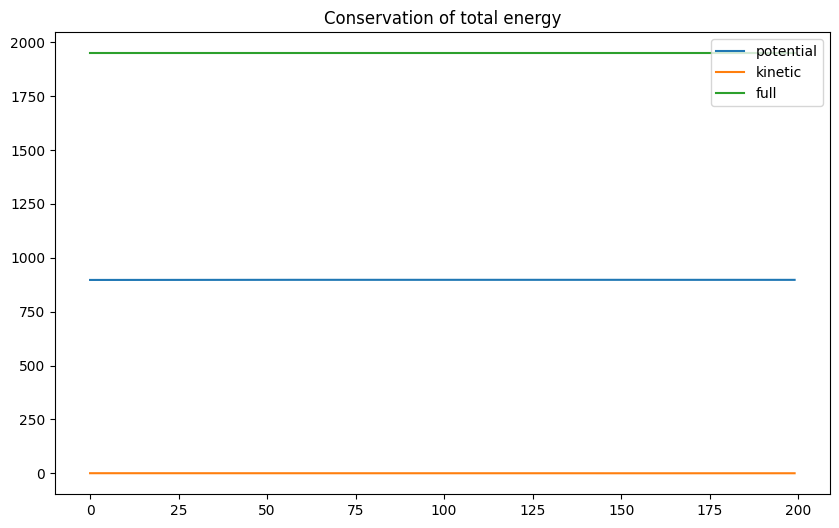

In [ ]:
cube = System('fcc', 3, size=3.6, start_v=False)

test = open("stability.dump", 'w')
test.close()
# Test №1: FCC lattice stability at initial temperature
for _ in tqdm(range(200)):
  cube.verlet(dt = 0.01)
  cube.dump("stability.dump", 'a')

# Test №3: Conservation of full energy
plt.figure(figsize=(10, 6))
const = 3000

plt.plot(-np.array(cube.energy)[:, 1] + const, label='potential')
plt.plot(np.array(cube.energy)[:, 2], label='kinetic')
plt.plot(-np.array(cube.energy)[:, 1]/2 + np.array(cube.energy)[:, 2] + const, label='full')

plt.title("Conservation of total energy")
plt.legend()
plt.show()

In [ ]:
cube2 = System('fcc', 3, size=3.6, temperature=0.1, start_v=False)
# Test №2: Melting
for _ in tqdm(range(500)):
  cube2.verlet(dt = 0.01)
  cube2.dump("melting.dump", 'a')

  0%|          | 0/500 [00:00<?, ?it/s]

Bulk Modulus: -2.542472414501323e-16


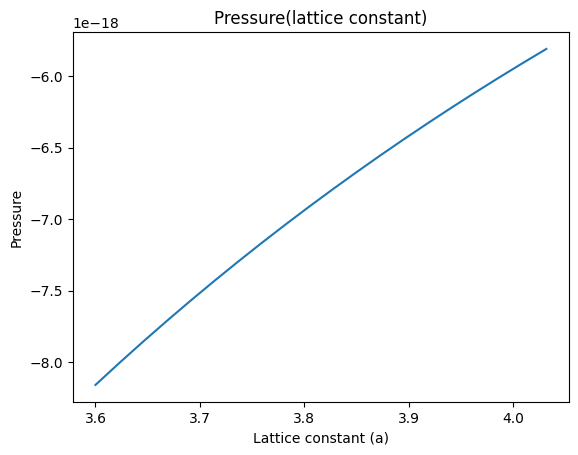

In [ ]:
# Test №4: Modulus of all-round compression calculation

#cube = System('fcc', 3, size=3.6, start_v=False)
size = 3.6
V_0 = cube.volume
p_val = []
lattice_a = np.linspace(1, 1.12, 20) * size

for a in lattice_a:
    cube.size = size * a
    cube.volume = V_0 * a**3
    p_val.append(cube.calculate_pressure())

dP_dV = np.gradient(p_val, lattice_a)
b = -V_0 * np.mean(dP_dV)
print("Bulk Modulus:", b)

plt.plot(lattice_a, p_val)
plt.xlabel('Lattice constant (a)')
plt.ylabel('Pressure')
plt.title('Pressure(lattice constant)')
plt.show()

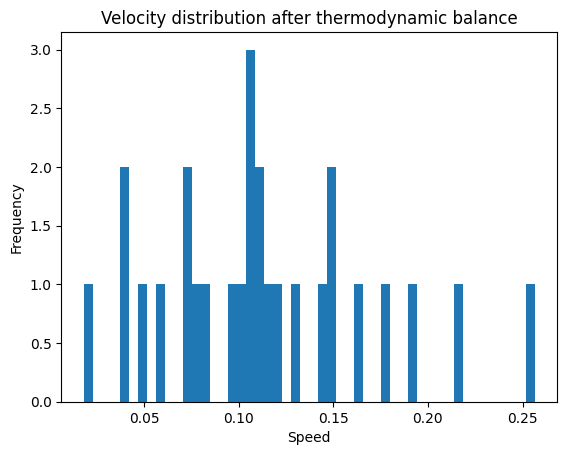

In [ ]:
plt.hist(np.linalg.norm(cube.V, axis=1), bins=50)
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title("Velocity distribution after thermodynamic balance")
plt.show()

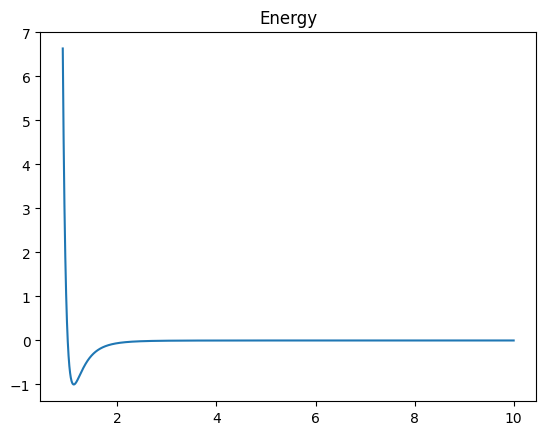

In [ ]:
'''Side calculations'''
def l_j(r, eps, sigma):
    return 4 * eps*((sigma/r)**12 - (sigma/r)**6)

r_ar = np.arange(0.9, 10, 0.001)

y = l_j(r_ar, 1, 1)
#print(y)
m = min(y)

ind = np.where(y==m)[0][0]
#print(ind)
#print(r_ar[ind])
plt.plot(r_ar, y)

plt.title("Energy")
plt.show()